In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Getting the data

In [2]:
dir = '/kaggle/input/digit-recognizer/'
X_train = pd.read_csv(dir + 'train.csv')
X_test = pd.read_csv(dir + 'test.csv')

In [3]:
print('Train Data dimensions: ', X_train.shape)
print('Test Data dimensions: ', X_test.shape)

Train Data dimensions:  (42000, 785)
Test Data dimensions:  (28000, 784)


In [4]:
y_train = X_train.iloc[:,0] # Separate the labels from the rest of the training data
X_train = X_train.iloc[:,1:]

# Visualize the training data

In [5]:
def visualize_image(image_arr):
    image_mat = (np.array(image_arr)).reshape((28, 28))
    plt.imshow(image_mat, cmap='binary')
    plt.axis('off')

def visualize_multiple_images(image_idx_arr):
    figure = plt.figure(figsize=(12, 8))
    rows, cols, i = 10, 10, 1
    for idx in image_idx_arr:
        figure.add_subplot(rows, cols, i)
        visualize_image(X_train.iloc[idx,:])
        i = i + 1

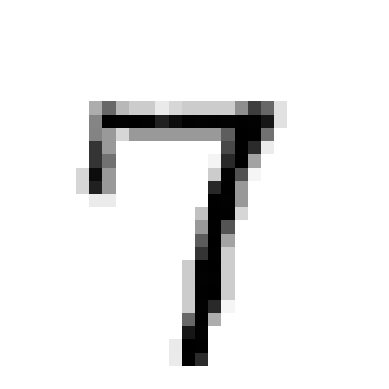

In [6]:
visualize_image(X_train.iloc[6,:])

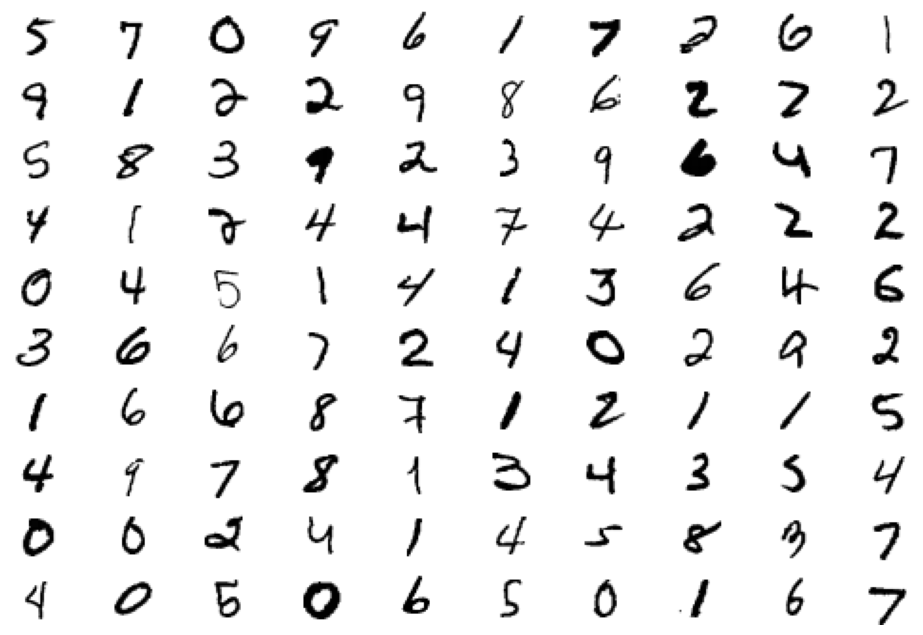

In [7]:
shuffled_indices = np.random.permutation(len(X_train))
visualize_multiple_images(shuffled_indices[:100])

# Binary Classification

## Train a '9-classifier' to check if a digit is 9 or not.

In [8]:
y_train_9 = (y_train == 9)

In [9]:
# Use Stochastic Gradient Descent classifier (SGD classifier). It is an efficient starting point since it deals with the training instances separately. Also suited for online training.

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_9)

SGDClassifier(random_state=42)

[False]


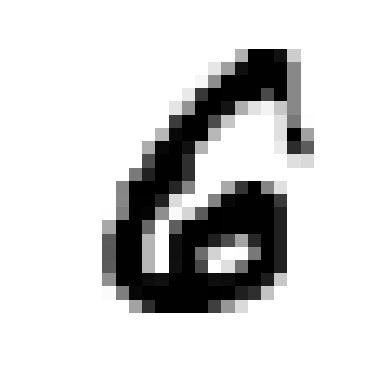

In [10]:
# Predict for a random digit
random_idx = np.random.randint(0, 42000)
print(sgd_clf.predict([np.array(X_train.iloc[random_idx,:])]))
visualize_image(X_train.iloc[random_idx,:])

# Validation and performance measures

## 1. Measuring accuracy using cross validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.95114286, 0.92321429, 0.92607143])

### Although we do get accuracy >92%, this is not reliable since the dataset is skewed with respect to the classes. Here the 'non-9' class is much more frequent as compared to the '9' class. Therefore we cannot trust accuracy to be a valid measure for checking the performance of the model.

## 2. Confusion Matrices

### Confusion matrix basically is a matrix which contains the count of instances of class A that are incorrectly classified as class B for all such A/B pairs. For instance, if we want to check how many number of instances of '4' were incorrectly classified as '5', then we check the row-4 and column-5 of the confusion matrix.

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_9, y_train_pred)
cm

# Read below confusion matrix as:
#             |      non-9 class     |        9 class
# -------------------------------------------------------------
# non-9 class | True negatives (TN)  |  False positives (FP)
# -------------------------------------------------------------
# 9 class     | False negatives (FN) |  True positives (TP)
# 
# False positives -> Type I error
# False negatives -> Type II error

array([[36429,  1383],
       [ 1411,  2777]])

## 3. Precision and Recall

In [14]:
# Precision: accuracy of the prositive predictions
# Precision = TP / (TP + FP)

# Recall: sensitivity of the positive predictions or True Positive Rate (TPR).
# Recall = TP / (TP + FN)

# Trivial way to have perfect precision classifier is to predict all samples as negative except for one single positive instance for which the model is most confident. In this case FP->0 and TP=1 giving a 100% precision classifier. Therefore we combine precision with recall to give a balanced metric.